# Exercise 09: Distance Based Utility Model

- Agent's utility depends on \textbf{direct} \textbf{and} \textbf{indirect} connections
    - Connections are \textbf{undirected} $\to$ counted twice
    - Number of direct connections (\textbf{links}):  Degree $d_{i}$ 
    - \textbf{Length} $l_{ij}$ of \textbf{shortest path} between $i$ and $j$ (\# of hops)
    - If $(i,j)$ are not connected by a path: $l_{ij}\to \infty$
    - \textbf{Benefit} $b(l)$ \textbf{decreases}  with distance $l$
    - \textbf{Cost} per link is constant, $c$, agents maintain their direct links
- *Utility* of agent $i$: $$ u_{i} = \sum_{j \neq i} b(l_{ij}) - c\,d_i $$
    1. Choice of $b(l)$: $\delta^{l}$ with $0<\delta<1$ $\to \delta$, $\delta^{2}$, ... (``connections model'')
    2. Choice of $b(l)$: $b(1)=b_{1}>b(2)=b_{2}$, $b(l>2)=0$
- item Is it beneficial for agents to create links?
    - Reduce costs $\to$ less \textbf{direct} links 
    - Increase benefits $\to$ more \textbf{direct/indirect} links, dependent on $b_{1}$, $b_{2}$


In [1]:
import mesa
import numpy as np
import networkx as nx
import random

from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
from visualization_functions import plot_network

## Section 1: Implement customs schedulers

Mesa's RandomActivation scheduler activates all agents in a random order at each step.
If we want to see how the different activation orders affect the model, we need to implement a custom scheduler that will activate agents in a random order, but only once per step.

`RandomSingleActivation` provides the code for a custom scheduler that activates one agent at random per step.
However, the same agent may be activated multiple times before all agents have been activated once.
Modify this code to create a custom scheduler that activates agents in a random order, ensuring that all agents are activated once before any agent is activated a second time.

In [2]:
class RandomSingleActivation(mesa.time.BaseScheduler):
    """A scheduler to activate only one random agent per step."""
    def step(self):
        if self.agents:
            agent = random.choice(self.agents)
            agent.step()
            
        self.steps += 1
        self.time += 1


In [3]:

class RandomOrderedSingleActivation(mesa.time.BaseScheduler):
    """
    A scheduler to activate only one random agent per step. The order of agents is shuffled. 
    An agent is activated again only after all other agents have been activated.
    """
    def step(self):
        if self.agents and self.time % len(self.agents) == 0:
            random.shuffle(self.agents)
        
        if self.agents:
            agent = self.agents[self.time % len(self.agents)]
            agent.step()
            
        self.steps += 1
        self.time += 1

## Section 2: Implement the Distance Based Utility Model
Implement two variants of the benefit funtion:
- `benefit1`: $b(l) = \delta^{l}$ with $0<\delta<1$
- `benefit2`: $b(1)=b_{1}>b(2)=b_{2}$, $b(l>2)=0$

In [4]:
# agent class

class Agent(mesa.Agent):
    """
    Agent class for the network formation model.
    """

    def __init__(self, model:"World", unique_id):
        super().__init__(unique_id, model)
    
    # ==== Properties ====
    @property
    def uid(self):
        """unique agent identifier, useful for matching agents to network nodes"""
        return self.unique_id

    @property
    def cost(self):
        """cost of sustaining a link"""
        return self.model.cost

    def degree(self):
        """get number of neighbors from the network"""
        return self.model.net.degree(self.uid)
    
    def neighbors(self):
        """return the sequence of neighbors of the focal agent"""
        for uid in self.model.net.neighbors(self.uid):
            yield self.model.schedule.agents[uid]
    
    def non_neighbors(self):
        """return the sequence of non-neighbors of the focal agent"""
        neighbors = set(a.uid for a in self.neighbors())
        all_nodes = set(self.model.uids()) - {self.uid}
        valid_uids = all_nodes - neighbors
        for uid in valid_uids:
            yield self.model.schedule.agents[uid]

    def component_uids(self, network = None):
        """returns the uids of the component in which this agent resides"""
        if network is None:
            network = self.model.net
        my_comp = [c for c in nx.connected_components(network) if self.uid in c][0]
        return my_comp

    def subgraph(self, network = None, copy=False):
        """The graph induced by selecting only the component to which the agent belongs."""
        if network is None:
            my_component = self.component_uids()
            network = self.model.net
        else:
           my_component = self.component_uids(network)

        sub_graph = nx.subgraph(network, my_component)
        if copy:
            return sub_graph.copy()
        return sub_graph

    # === Basic Actions ===
    def create_link_to(self, other):
        """Create a connection between this agent and the other agent."""
        self.model.create_link(self, other)

    def delete_link_to(self, other):
        """Deleted link to other agent"""
        self.model.delete_link(self, other)

    # === decision variables ===
    def utility(self, subgraph):
        """
        The utility for the agent given his position in the network."""
        # compute the shortest path length to all other agents in the subgraph:
        shortest_path_lengths = nx.single_source_shortest_path_length(subgraph, self.uid)
        degree = subgraph.degree[self.uid]
        utility = sum(self.benefit(shortest_path_lengths)) - self.cost * degree

        return utility
    
    def benefit2(self, shortest_path_lengths):
        """Compute the benefit for the agent given the shortest path lengths to all other agents."""
        benefits = []
        for uid, distance in shortest_path_lengths.items():
            if distance == 0:
                continue
            elif distance == 1:
                benefits.append(self.model.b1)
            elif distance == 2:
                benefits.append(self.model.b2)
            else:
                continue
        return benefits

    def benefit(self, shortest_path_lengths):
        """Compute the benefit for the agent given the shortest path lengths to all other agents."""
        benefits = []
        for uid, distance in shortest_path_lengths.items():
            if distance == 0:
                continue
            benefits.append(self.model.delta**distance)
        return benefits

    # === potential outcomes ===
    def subgraph_if(self, add_link_to=None, remove_link_to=None):
        """Construct a hypothetical subgraph if the given changes were to be applied."""
        if add_link_to is None and remove_link_to is None:
            raise ValueError(
                "At least one of `add_connections` or `remove_connections` must be"
                "specified."
            )

        if add_link_to and not hasattr(add_link_to, "__iter__"):
            add_link_to = [add_link_to]

        if remove_link_to and not hasattr(remove_link_to, "__iter__"):
            remove_link_to = [remove_link_to]

        edges_to_remove_after = []
        if add_link_to:
            for other in add_link_to:
                if not self.model.link_exists(self, other):
                    self.create_link_to(other)
                    edges_to_remove_after.append(other)

        edges_to_add_after = []
        if remove_link_to:
            for other in remove_link_to:
                if self.model.link_exists(self, other):
                    self.delete_link_to(other)
                    edges_to_add_after.append(other)

        # save a copy of the focal subgraph
        net = self.model.net
        subgraph = self.subgraph(net, copy=True)

        # Revert Changes
        for other in edges_to_remove_after:
            self.delete_link_to(other)

        for other in edges_to_add_after:
            self.create_link_to(other)

        return subgraph

    def gain_from_link(self, other, create=True):
        """Compute the gain if the proposed link is created/deleted from the focal agents
        perspective."""
        links_exists_already = self.model.link_exists(self, other)
        if create is True and links_exists_already:
            return 0.0

        if create is False and not links_exists_already:
            return 0.0

        if create is True:
            potential_subgraph = self.subgraph_if(add_link_to=other)
        elif create is False:
            potential_subgraph = self.subgraph_if(remove_link_to=other)
        else:
            raise ValueError(f"`create` must be either True or False, not {create}")

        actual_utility = self.utility(self.subgraph())
        potential_utility = self.utility(potential_subgraph)

        return potential_utility - actual_utility

    def rank_agents(self, create=True, max_sample=None):
        """Create a ranking of `max_sample` agents for the focal agent to create/delete a link to."""
        if create is True:
            valid_set = list(self.non_neighbors())
        elif create is False:
            valid_set = list(self.neighbors())
        else:
            raise ValueError(f"`create` must be either True or False, not {create}")

        if max_sample and max_sample < len(valid_set):
            chosen_uids = random.choices(valid_set, k=max_sample)
        else:
            random.shuffle(valid_set)
            chosen_uids = valid_set

        gains_from_agent = {}
        for other_agent in chosen_uids:
            gain = self.gain_from_link(other_agent, create=create)
            if gain > 0:
                gains_from_agent[other_agent.uid] = gain

        gains_and_uids = [(gain, agent) for agent, gain in gains_from_agent.items()]
        sorted_agents = sorted(gains_and_uids, reverse=True)
        return sorted_agents

    def best_action(self, mutual_create=True, mutual_delete=True, max_sample=None):
        """Returns the type of action to perform and with which agent that would
        maximize the utility if the action were to be carried out.

        Args:
            mutual_create (bool): require that both agents do not suffer utility losses (True) or in
                case of False only consider the utility of the proposing agent.
            mutual_delete (bool): delete only if both gain or if False only if the focal gains, but
                not necessarily the other
            max_sample (int): how many agents to sample to make the decision

        Returns:
            bool, Agent: True -> create | False -> delete, Agent to perform the action on.

        Examples:
            >>> w = World(n=2)
            >>> agent0 = w[0]
            >>> agent0.best_action()
            (True, Agent(<World>, uid=1))
        """
        # best create action
        create_gain, top_create_target = self.best_simple_action(
            True, mutual_create, max_sample
        )
        # best delete action
        delete_gain, top_delete_target = self.best_simple_action(
            False, mutual_delete, max_sample
        )
        if top_create_target and top_delete_target:  # we have two viable options
            if create_gain >= delete_gain:
                return True, top_create_target
            else:
                return False, top_delete_target
        elif top_create_target:  # only create is viable
            return True, top_create_target
        elif top_delete_target:  # only delete is viable
            return False, top_delete_target
        else:  # no viable option is available
            return None, None
        
    def best_simple_action(self, create=True, mutual=True, max_sample=None):
        """Return the agent with whom a link created/delete would yield the highest utility gain

        Args:
            create (bool): if True then the the best "link creation" target is chosen otherwise
                deletion.
            mutual (bool): default True, if `mutual` is True then then all possible candidates are
                ranked according to the gain they would provide if the action were to be executed.
                Then the first agent from this raking that would accept the offer (i.e. he does not
                lose) is chosen. This results in the highest possible payoff for the focal agent
                without reducing the gain of the other
            max_sample (int): number of agents to rank, if not specified all agents are considered
                valid targets. if a number is given the agent will randomly sample `max_samples`
                to compute his ranking.
        Returns:
            Agent or None, None indicates that the best action is to do nothing
        """
        ranked_gains_uid = self.rank_agents(create, max_sample)

        if not ranked_gains_uid:
            return 0.0, None

        if not mutual:
            gain, chosen_uid = ranked_gains_uid[0]
            return gain, self.model.schedule.agents[chosen_uid]  # returns the first one

        for gain_from_other, other_uid in ranked_gains_uid:
            gain_other = self.model.schedule.agents[other_uid].gain_from_link(self, create)
            if gain_other >= 0:
                return gain_from_other, self.model.schedule.agents[other_uid]
        return 0.0, None

    # === Update Rules ===
    def best_action_update(
        self, mutual_creation=True, mutual_deletion=False, max_sample=None
    ):
        """Create/Delete or do nothing according to the action that maximizes the gain.

        Args:
            mutual_creation: require that neither agent is worse off when creating the link
            mutual_deletion: require that neither agent is worse off when deleting the link
            max_sample (int): sample of agents to evaluate create/delete action for,
                defaults to all agents

        """
        create, target_agent = self.best_action(
            mutual_creation, mutual_deletion, max_sample
        )
        if target_agent is not None:
            if create is True:
                self.create_link_to(target_agent)
            elif create is False:
                self.delete_link_to(target_agent)

    def step(self):
        max_sample = self.model.max_sample
        mutual_create = self.model.mutual_create
        mutual_delete = self.model.mutual_delete

        self.best_action_update(mutual_create, mutual_delete, max_sample)

In [5]:
# Model class
class World(mesa.Model):
    """The World class represents the environment in which the Agents interact.

    The class keeps track of the Network on which the agents interact, the alterations to it
    over time as well as the model time
    """

    def __init__(self, num_agents, cost,
                 mutual_create, 
                 mutual_delete,
                 delta,
                    b1,
                    b2,
                 poling_interval=1, 
                 check_stability=1, 
                 max_steps=None,
                 max_sample=None,
                 plot_network=False
                 ):
        super().__init__()
        self.schedule = RandomSingleActivation(self)
        self.net = nx.Graph()
        self.max_sample = max_sample
        self.cost = cost
        self._id_counter = 0
        self.poling_interval = poling_interval
        self.check_stability = check_stability
        self.mutual_create = mutual_create
        self.mutual_delete = mutual_delete
        self.max_steps = max_steps
        self.num_agents = num_agents
        self.delta = delta
        self.b1 = b1
        self.b2 = b2
        self.plot = plot_network

        self.add_agents(num_agents)

        self.datacollector = DataCollector(
            {
                "welfare": lambda m: m.aggregate_welfare(),
                "density": lambda m: m.density(),
                "clustering": lambda m: m.clustering(),
                "num_components": lambda m: len(list(m.connected_components())),
            }
        )

    # === Basic Actions ===

    def _generate_uid(self):
        """generate a unique uid"""
        valid_id_found = False
        uid = None
        while not valid_id_found:
            uid = self._id_counter
            valid_id_found = uid not in self.net
            self._id_counter += 1
        return uid

    def add_agents(self, num_agents):
        """Add the specified number of agents or ids in agent_list to the World.
        """
        for _ in range(num_agents):
            self.add_agent()

    def add_agent(self):
        """Add a single Agent to the simulation
        """
        uid = self._generate_uid() # generate a unique uid for the agent in the network
        if uid in self.net:
            raise KeyError(f"`uid={uid}` already taken")

        agent = Agent(self, uid)
        self.schedule.add(agent)
        self.net.add_node(uid)

    def remove_agent(self, agent_uid: int):
        """Remove the given agent uid from the World"""
        self.schedule.remove(self.agent(agent_uid))
        self.net.remove_node(agent_uid)

    def create_link(self, agent_1:Agent, agent_2:Agent):
        """Connect the two agents in the network"""
        self.net.add_edge(agent_1.uid, agent_2.uid)

    def delete_link(self, agent_1: Agent, agent_2: Agent):
        """Delete the link between the two agents in the network"""
        self.net.remove_edge(agent_1.uid, agent_2.uid)

    # === properties ===
    def uids(self):
        for agent in self.agents():
            yield agent.uid

    def agents(self):
        """A list of all agents currently active in the simulation

        Yields:
            Agent
        """
        for agent in self.schedule.agents:
            yield agent

    # === Network properties ===
    def aggregate_welfare(self):
        """Compute aggregated welfare (i.e. the sum of all utilities) of the agents in the network
        """
        welfare = sum(a.utility(a.subgraph()) for a in self.schedule.agents)
        return welfare

    def density(self):
        """Returns the proportion of possible edges which are actually present"""
        return nx.density(self.net)

    def clustering(self):
        """See networkx.average_clustering"""
        return nx.average_clustering(self.net)

    # def degree(self):
    #     """Number of neighbors in the Graph"""
    #     return self.net.degree

    def connected_components(self):
        """Returns a generator containing the uids of the current network

        Yields:
            sets of uids in the same component
        """
        return nx.connected_components(self.net)

    def link_exists(self, agent_1: Agent, agent_2: Agent):
        """Return True if a link exists False otherwise"""
        edge = (agent_1.uid, agent_2.uid)
        return edge in self.net.edges()

    # === Stability Checks (to stop simulation) ===
    def is_pairwise_stable(self, agents=None, mutual_create=True, mutual_delete=True):
        """Return true if no agent would be willing to make a change (either create or delete)

        Args:
            agents (list of Agents): if the stability should only be checked for this subset pass a
                list of agents otherwise the stability is computed considering all agents
            mutual_create (bool): require that neither agent is worse off when creating the link
            mutual_delete (bool): require that neither agent is worse off when deleting the link

        Returns:
            Returns True if no agent wants to make a move, False otherwise
        """
        # short circuit logic to reduce the number of comparisons necessary to find that the
        # system is not stable (i.e. at least one agent wants to make a move).
        # If it is in fact stable all agents need to be tested
        deletion_stable = self.is_deletion_stable(agents, mutual=mutual_delete)

        if deletion_stable is False:  # the first test is False -> all is False
            return False

        # The first test has yielded True if the next test is False -> all is False
        creation_stable = self.is_creation_stable(agents, mutual=mutual_create)
        return creation_stable

    def is_deletion_stable(self, agents=None, mutual=True):
        """Returns True if no Agent would be willing to delete a link"""
        return self._is_simple_action_stable(agents, create=False, mutual=mutual)

    def is_creation_stable(self, agents=None, mutual=True):
        """Returns True if no Agent would be willing to create one more edge"""
        return self._is_simple_action_stable(agents, create=True, mutual=mutual)

    def _is_simple_action_stable(self, agents=None, create=True, mutual=True):
        """Given either create=True or create=False (i.e. delete) the function returns True if no
        Agent would be willing to perform an action of the given type."""
        if agents is None:
            agents = self.schedule.agents

        for agent in agents:
            assert agent is not None, "Agent is None"
            _, other_agent = agent.best_simple_action(create, mutual)
            if other_agent is not None:
                return False
        return True
    
    def step(self):
        # at given interval report on the state of the system
        if self.schedule.time % self.poling_interval == 0:
            self.datacollector.collect(self)
            if self.plot:
                plot_network(self)
            
        self.schedule.step()
        plt.show()
        check_stability = self.check_stability
        mutual_create = self.mutual_create
        mutual_delete = self.mutual_delete
    

        if check_stability and (self.schedule.time % check_stability == 0):
            if self.is_pairwise_stable(
                mutual_create=mutual_create, mutual_delete=mutual_delete
            ):
                self.running = False
        
        if self.max_steps and self.schedule.time >= self.max_steps:
            self.running = False

## Section 3: Run the model and explore the parameter space.
- Do your results match what discussed in the lecture?
- What happens if you start with a network with no links?
- What happens if you start with a network with all possible links?
- What happens if you change the cost of maintaining a link?
- What happens if you change the benefit function?

/Users/lucaverginer/mambaforge/envs/edc/lib/python3.11/site-packages/mesa/time.py:82: FutureWarning: The AgentSet is experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1919
  self._agents: AgentSet = AgentSet(agents, model)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

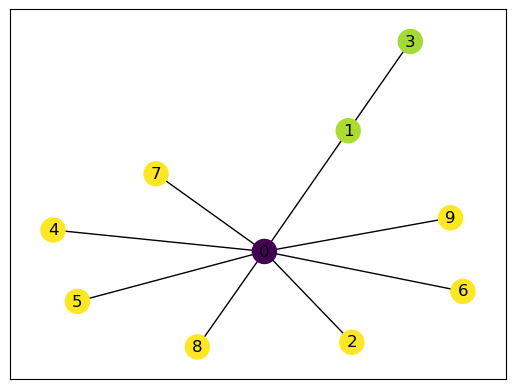

In [6]:
world = World(num_agents=10,
              cost=0,  
              mutual_create=True,
              mutual_delete=False,
              b1 = 0.9, b2 = 0.4,
              delta = .9,
              max_steps=1000,
              plot_network=False)
world.run_model()
world.cost = .6
world.running = True
world.run_model()
plot_network(world)
plt.show()

df = world.datacollector.get_model_vars_dataframe()
df.plot(subplots=True, figsize=(10, 10))
plt.show()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

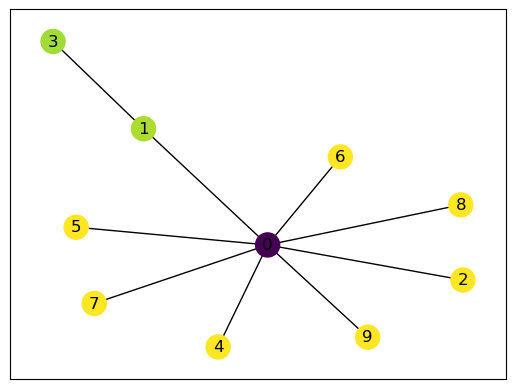

In [14]:
plot_network(world)